In [200]:
#!g1.1
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Детекция на основе SSD для датасета BCCD

Применим алгоритм SSD на основе VGG для детекции клеток крови на изображениях

### Подготовка данных

Загрузим изображения и разметку, сбалансируем классы и разделим изображения на тренировочные и валидационные. Тромбоцитов на картинках сильно больше (10x) поэтому просто уберем часть данных. 

In [ ]:
#!g1.1
# Скачиваем и распаковываем репозиторий с датасетом
!wget https://github.com/Shenggan/BCCD_Dataset/archive/refs/heads/master.zip
!unzip master.zip

# Экспортируем данные в test.csv
!python3 BCCD_Dataset-master/export.py

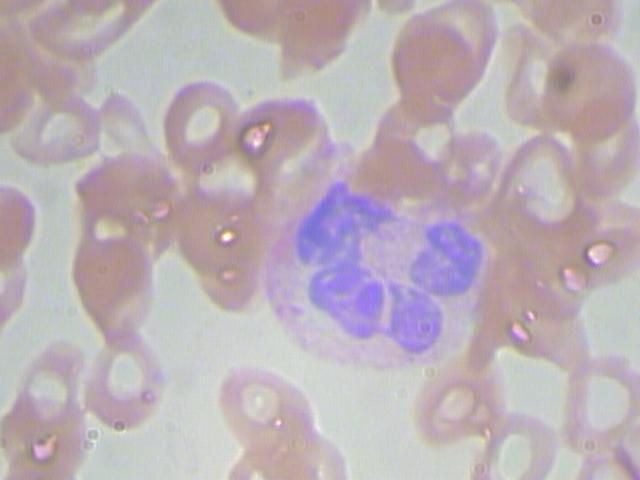

In [201]:
#!g1.1
# Посмотрим на пример изображения
from PIL import Image
Image.open('BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00000.jpg')

In [202]:
#!g1.1
# Читаем датафреймы с bbox'ами
import pandas as pd

img_width = 640
img_height = 480

df = pd.read_csv('BCCD_Dataset-master/test.csv')
df['cell_type'] = df['cell_type'].replace({'WBC': 1, 'RBC': 2, 'Platelets': 3})

df['xmin'] = df['xmin']/img_width
df['xmax'] = df['xmax']/img_width
df['ymin'] = df['ymin']/img_height
df['ymax'] = df['ymax']/img_height

df.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,1,0.406250,0.767188,0.368750,0.783333
1,BloodImage_00000.jpg,2,0.121875,0.287500,0.700000,0.906250
2,BloodImage_00000.jpg,2,0.098437,0.264062,0.493750,0.700000
3,BloodImage_00000.jpg,2,0.334375,0.500000,0.754167,0.960417
4,BloodImage_00000.jpg,2,0.646875,0.790625,0.733333,0.927083


In [203]:
#!g1.1
wbc_df = df[(df['cell_type'] == 1)]
plataletes_df = df[(df['cell_type'] == 3)]
rbc_df = df[(df['cell_type'] == 2)].head(750)

df = pd.concat([wbc_df, plataletes_df, rbc_df])

In [204]:
#!g1.1
# Разделим данный на тренировочные и проверочные

import random

filenames = list(df['filename'])
random.shuffle(filenames)

train_size = int(0.9 * len(filenames))

train_filenames = filenames[0:train_size]
test_filenames = filenames[train_size:]

print("%s train images" % len(train_filenames))
print("%s test images" % len(test_filenames))

1334 train images
149 test images


### Подготовка датасетов

Объявим специфичный датасет BCCDDataset для получения изображений и разметки по именам файлов

In [205]:
#!g1.1
# Объявим класс для нашего датасета, который можно будет использовать в DataLoader 

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import json
import os

train_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

class BCCDDataset(Dataset):
    def __init__(self, dataframe, filenames):
        self.dataframe = dataframe
        self.filenames = filenames

    def __getitem__(self, i):
        filename = self.filenames[i]
        dataframe = self.dataframe
        
        image = Image.open('BCCD_Dataset-master/BCCD/JPEGImages/' + filename, mode='r')
        image = image.convert('RGB')
        
        objects = dataframe[dataframe['filename']==filename]
        boxes = torch.FloatTensor(objects[['xmin', 'ymin', 'xmax', 'ymax']].values)
        labels = torch.LongTensor(list(objects['cell_type'].values))

        return train_transform(image), boxes, labels

    def __len__(self):
        return len(self.filenames)

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  

In [206]:
#!g1.1
train_dataset = BCCDDataset(df, train_filenames)
test_dataset = BCCDDataset(df, test_filenames)

### Модель и обучения

Импортируем модель SSD640 и обучим ее на изображениях датасета по трем классам (условно четырем, включая фон):

1. Лейкоциты
2. Эритроциты
3. Тромбоциты
 
Адаптируем решение, предложенное для ознакомления при подготовке к работе: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection. Что меняем:

1. В нашем случае изображения имеют VGA разрешение 640 на 480 пикселей. Поэтому модифицируем 1, 4 и 5 слои пулинга VGG модели, чтобы, во-первых, привести изображения к квадратной форме, а во-вторых иметь на входе сверточных слоев, заменяющих полносвязные слои VGG, размерность (N, 512, 19, 19).
2. В силу этих изменений имеем имеем иную размерность на выходе 4 сверточного слоя с низкоуровневыми особенностями, поэтому общее число anchor/prior boxes становится больше (а именно 9356). Поэтому меняем алгоритм генерации prior boxes, чтобы сгенерировать 9356 прямоугольника. 
3. Специфика данного датасета - довольно квадратные по отношению сторон области детектирования. Поэтому можем сильно сузить разброс ratio при генерировании prior boxes.
4. Убираем часть параметров из фунции детектирования и функции потерь (MultiBoxLoss), так как в этом датасете они не представлены (например difficulties).

In [207]:
#!g1.1
import time
import torch.optim
import torch.utils.data
from utils import *

print_freq = 100

def train(train_loader, model, criterion, optimizer, scheduler, epoch):
    model.train()
    start = time.time()

    for i, (images, boxes, labels) in enumerate(train_loader):
        data_time = time.time() - start

        images = images.to(device)  # (N, 3, 640, 480)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_loss = loss.item()
        batch_time = time.time() - start
        start = time.time()
        cur_lr = scheduler.get_last_lr()[0];

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time:.3f} \t'
                  'Data Time {data_time:.3f} \t'
                  'Loss {loss:.4f} \t'
                  'Learning rate {lr:.6f} \t'
                  .format(epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time, loss=cur_loss, lr=cur_lr))
            
    scheduler.step()
    del predicted_locs, predicted_scores, images, boxes, labels

In [208]:
#!g1.1
from model import SSD640, MultiBoxLoss
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR

model = SSD640(n_classes=4)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.98)

model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, threshold=0.8, neg_pos_ratio=3, alpha=1.).to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=train_dataset.collate_fn
)

for epoch in range(50):
    train(
        train_loader=train_loader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epoch
    )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 63.2MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Loaded base model.

Epoch: [0][0/84]	Batch Time 2.096 	Data Time 0.198 	Loss 19.0615 	Learning rate 0.000100 	
Epoch: [1][0/84]	Batch Time 0.461 	Data Time 0.181 	Loss 3.3459 	Learning rate 0.000098 	
Epoch: [2][0/84]	Batch Time 0.450 	Data Time 0.169 	Loss 3.1541 	Learning rate 0.000096 	
Epoch: [3][0/84]	Batch Time 0.450 	Data Time 0.169 	Loss 2.8565 	Learning rate 0.000094 	
Epoch: [4][0/84]	Batch Time 0.448 	Data Time 0.168 	Loss 2.7014 	Learning rate 0.000092 	
Epoch: [5][0/84]	Batch Time 0.450 	Data Time 0.169 	Loss 2.4746 	Learning rate 0.000090 	
Epoch: [6][0/84]	Batch Time 0.447 	Data Time 0.166 	Loss 1.9369 	Learning rate 0.000089 	
Epoch: [7][0/84]	Batch Time 0.463 	Data Time 0.182 	Loss 1.0040 	Learning rate 0.000087 	
Epoch: [8][0/84]	Batch Time 0.453 	Data Time 0.171 	Loss 0.5310 	Learning rate 0.000085 	
Epoch: [9][0/84]	Batch Time 0.456 	Data Time 0.176 	Loss 0.4597 	Learning rate 0.000083 	
Epoch: [10][0/84]	Batch Time 0.449 	Data Time 0.167 	Loss 0.2880 	Learning rat

### Оценка результатов

Проверим результат обучения на валидационном датасете. Используем функцию Mean Average Precision, чтобы увидеть точность по каждому из классов.

In [209]:
#!g1.1
from tqdm import tqdm
from model import SSD640, MultiBoxLoss
from utils import *

model.eval()

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=test_dataset.collate_fn
)

det_boxes = list()
det_labels = list()
det_scores = list()
true_boxes = list()
true_labels = list()

with torch.no_grad():
    for i, (images, boxes, labels) in enumerate(tqdm(test_loader, desc='Evaluating')):
        images = images.to(device)  # (N, 3, 640, 480)

        predicted_locs, predicted_scores = model(images)
        det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores, min_score=0.9, max_overlap=0.1, top_k=100)

        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        det_boxes.extend(det_boxes_batch)
        det_labels.extend(det_labels_batch)
        det_scores.extend(det_scores_batch)
        true_boxes.extend(boxes)
        true_labels.extend(labels)

    APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels)
    
print(APs)
print('\nMean Average Precision (mAP): %.3f' % mAP)
    

Evaluating: 100%|██████████| 149/149 [00:04<00:00, 37.22it/s]


{'WBC': 0.9090909361839294, 'RBC': 0.7272727489471436, 'Platelets': 0.9090909361839294}

Mean Average Precision (mAP): 0.848


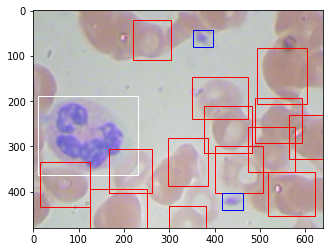

In [213]:
#!g1.1
# Взглянем на результат работы модели

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torchvision.transforms as transforms

img = Image.open('BCCD_Dataset-master/BCCD/JPEGImages/' + test_filenames[0])
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])
img = transform(img).to(device)
img = img.unsqueeze(0)

predicted_locs, predicted_scores = model(img)
predicted_bboxes, predicted_labels, predicted_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=0.9, max_overlap=0.2, top_k=20)


image = Image.open('BCCD_Dataset-master/BCCD/JPEGImages/' + test_filenames[0])
image_np = np.array(image)

fig, ax = plt.subplots(1)
ax.imshow(image_np)

color_map = {
    '1': 'w',
    '2': 'r',
    '3': 'b',
    '0': 'w'
}

bboxes = [[b[0] * img_width, b[1] * img_height, b[2] * img_width, b[3] * img_height] for b in predicted_bboxes[0].detach().to('cpu')]
for i, bbox in enumerate(bboxes):
    color = color_map[str(predicted_labels[0][i].item())]
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
plt.show()

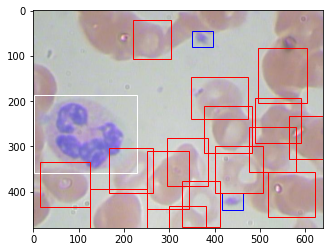

In [214]:
#!g1.1
# Сравним с разметкой

fig, ax = plt.subplots(1)
ax.imshow(image_np)

actual_bboxes = df[df["filename"] == test_filenames[0]][['xmin', 'ymin', 'xmax', 'ymax']].values
actual_bboxes = [[b[0] * img_width, b[1] * img_height, b[2] * img_width, b[3] * img_height] for b in actual_bboxes]
actual_labels = df[df["filename"] == test_filenames[0]]['cell_type'].values
for i, bbox in enumerate(actual_bboxes):
    color = color_map[str(actual_labels[i])]
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

plt.show()

### Итого

Реализовали SSD модель для детектирования и классификации клеток крови на изображениях. Модифицировали каноническое решение, учитывая специфику взятого датасета.

Худшие результаты при детектировании эритроцитов связаны с тем что этих объектов на порядок больше как в целом в крови, так и на изображениях датасета. А так как функция mAP учитывает как точность так и полноту (считается как среднее значение precision на различных уровнях recall), то бОльшая вероятность пропуска объектов этого класса отражается и на итоговых результатах. 

In [ ]:
#!g1.1
